# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import prince
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from scipy.stats import chi2_contingency, rankdata
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
# load data
df = pd.read_csv('data_for_models_project1.csv')

In [12]:
# divide data into train and test
X = df.drop('Y', axis=1)
y = df['Y']
# load txt file as y 
#y = np.loadtxt('y_pred_k_medoids_2.txt')


# Classification with variance/bias tradeoff methods

### Preprocessing and model identification

In [13]:
# Define model configurations
model_configs = [
    {
        'name': 'Random Forest',
        'classifier': RandomForestClassifier(n_estimators=500, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, random_state=42)
    },
    {
        'name': 'XGBoost',
        'classifier': XGBClassifier(
            n_estimators=1000,
            max_depth=15,
            learning_rate=0.01,
            subsample=0.5,
            colsample_bytree=0.5,
            gamma=0.1,
            random_state=42
        )
    },
]

### Holdout


Training Size: 10088, Test Size: 2522
----------------------------------------
Running Random Forest...


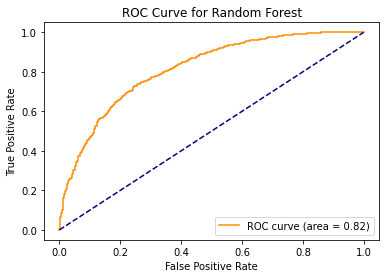

Random Forest F1 Score: 0.7749


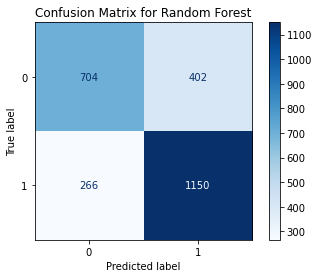

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1106
           1       0.74      0.81      0.77      1416

    accuracy                           0.74      2522
   macro avg       0.73      0.72      0.73      2522
weighted avg       0.73      0.74      0.73      2522

------------------------------------------------------------
Running XGBoost...


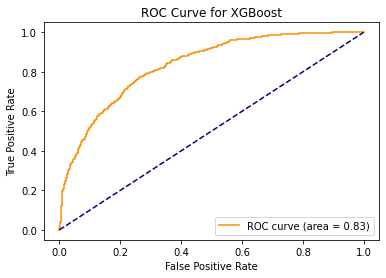

XGBoost F1 Score: 0.7859


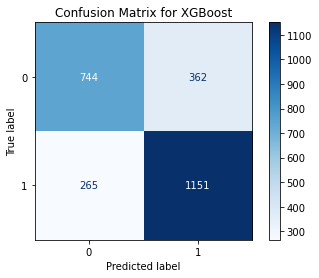

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1106
           1       0.76      0.81      0.79      1416

    accuracy                           0.75      2522
   macro avg       0.75      0.74      0.74      2522
weighted avg       0.75      0.75      0.75      2522

------------------------------------------------------------

Training Size: 9457, Test Size: 3153
----------------------------------------
Running Random Forest...


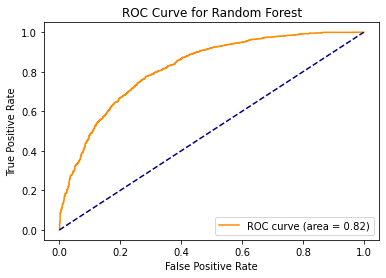

Random Forest F1 Score: 0.7868


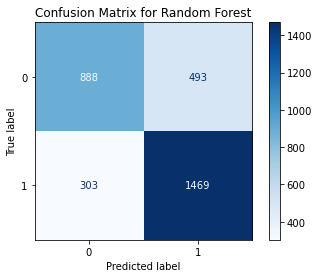

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1381
           1       0.75      0.83      0.79      1772

    accuracy                           0.75      3153
   macro avg       0.75      0.74      0.74      3153
weighted avg       0.75      0.75      0.74      3153

------------------------------------------------------------
Running XGBoost...


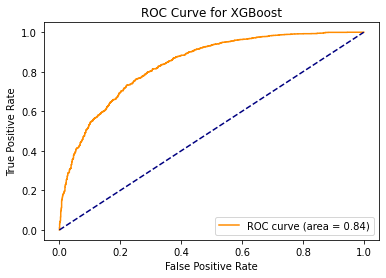

XGBoost F1 Score: 0.7954


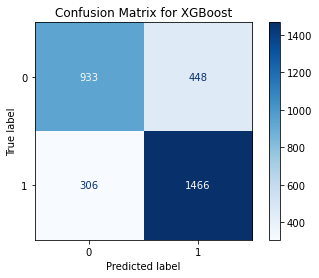

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      1381
           1       0.77      0.83      0.80      1772

    accuracy                           0.76      3153
   macro avg       0.76      0.75      0.75      3153
weighted avg       0.76      0.76      0.76      3153

------------------------------------------------------------

Training Size: 8827, Test Size: 3783
----------------------------------------
Running Random Forest...


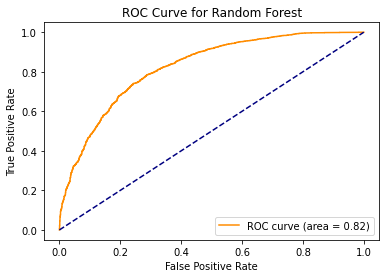

Random Forest F1 Score: 0.7888


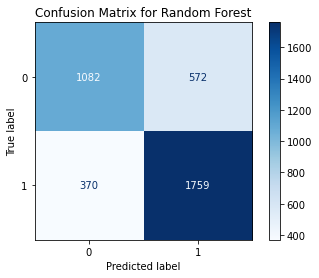

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1654
           1       0.75      0.83      0.79      2129

    accuracy                           0.75      3783
   macro avg       0.75      0.74      0.74      3783
weighted avg       0.75      0.75      0.75      3783

------------------------------------------------------------
Running XGBoost...


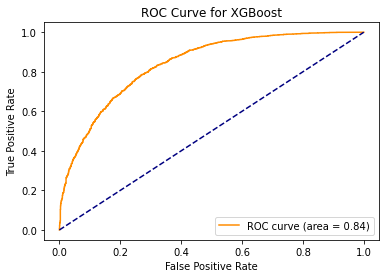

XGBoost F1 Score: 0.7975


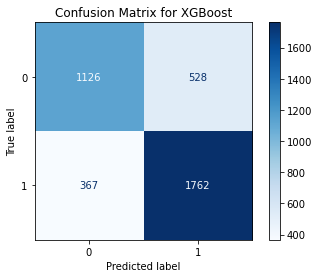

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.72      1654
           1       0.77      0.83      0.80      2129

    accuracy                           0.76      3783
   macro avg       0.76      0.75      0.76      3783
weighted avg       0.76      0.76      0.76      3783

------------------------------------------------------------


In [14]:
# Define a function to split data with multiple test sizes
def split_data_for_multiple_test_sizes(X, y, test_sizes):
    data_splits = []
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        data_splits.append((X_train, X_test, y_train, y_test))
    return data_splits

test_sizes = [0.2, 0.25, 0.3]  # This corresponds to 80%, 75%, and 70% training sizes
data_splits = split_data_for_multiple_test_sizes(X, y, test_sizes)

# Loop through the splits
for data in data_splits:
    X_train, X_test, y_train, y_test = data
    print(f"\nTraining Size: {len(X_train)}, Test Size: {len(X_test)}\n{'-'*40}")
    
    # Updated loop for models to include categorical columns
    for model_config in model_configs:
        print(f"Running {model_config['name']}...")
        
        X_train_processed = X_train
        X_test_processed = X_test

        X_train_processed = np.ascontiguousarray(X_train_processed)
        X_test_processed = np.ascontiguousarray(X_test_processed)

        model_config['classifier'].fit(X_train_processed, y_train)
    
        y_pred = model_config['classifier'].predict(X_test_processed)

        # ROC curve and AUC
        if len(set(y_test)) == 2:  # Ensure binary classification
            y_prob = model_config['classifier'].predict_proba(X_test_processed)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_config["name"]}')
            plt.legend(loc="lower right")
            plt.show()

        # F1 score
        f1 = f1_score(y_test, y_pred)
        print(f"{model_config['name']} F1 Score: {f1:.4f}")

        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot the confusion matrix using ConfusionMatrixDisplay
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_test))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_config["name"]}')
        plt.show()
        
        print(f"{model_config['name']} Classification Report:")
        print(classification_report(y_test, y_pred))
        print('-' * 60)

### K Cross-validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Number of splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over each model
for model_config in model_configs:
    
    accuracies = []
    print(f"Running {model_config['name']}...")
    
    # Cross-validation loop
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        X_train_processed = X_train_fold
        X_val_processed = X_val_fold

        X_train_processed = np.ascontiguousarray(X_train_processed)
        X_val_processed = np.ascontiguousarray(X_val_processed)

        model_config['classifier'].fit(X_train_processed, y_train_fold)
    
        y_pred_val = model_config['classifier'].predict(X_val_processed)
        # ROC curve and AUC
        if len(set(y_val_fold)) == 2:  # Ensure binary classification
            y_prob_val = model_config['classifier'].predict_proba(X_val_processed)[:, 1]
            fpr, tpr, _ = roc_curve(y_val_fold, y_prob_val)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {model_config["name"]}')
            plt.legend(loc="lower right")
            plt.show()

        # F1 score
        f1 = f1_score(y_val_fold, y_pred_val)
        print(f"{model_config['name']} F1 Score for current fold: {f1:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_val_fold, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_val_fold))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_config["name"]}')
        plt.show()

        # Accuracy for the fold
        fold_accuracy = accuracy_score(y_val_fold, y_pred_val)
        accuracies.append(fold_accuracy)
    
    avg_accuracy = sum(accuracies) / n_splits
    print(f"{model_config['name']} Average Accuracy over {n_splits} folds: {avg_accuracy:.4f}")
    print('-' * 60)

Running Random Forest...


KeyError: 'preprocess'

### Bootstrapping

Iteration 1/10
Running KNN...


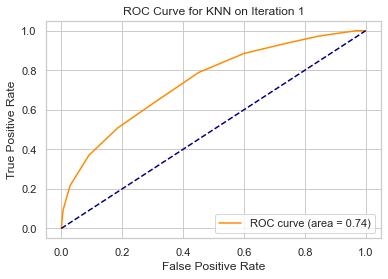

KNN F1 Score for Iteration 1: 0.7499


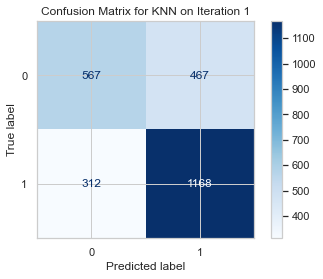

Running Naive Bayes...


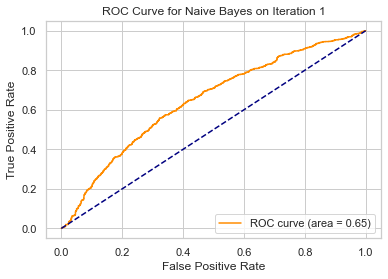

Naive Bayes F1 Score for Iteration 1: 0.6334


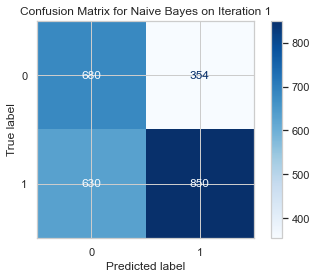

Running Random Forest...


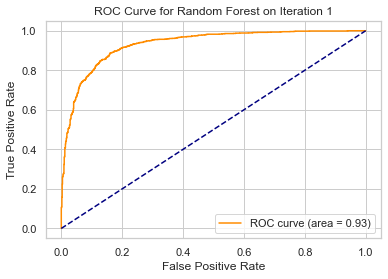

Random Forest F1 Score for Iteration 1: 0.8892


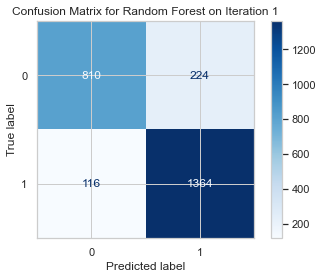

Running XGBoost...


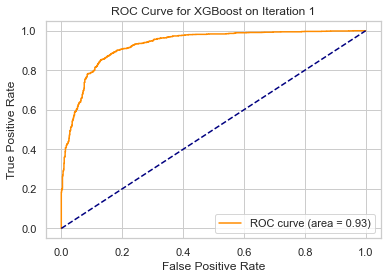

XGBoost F1 Score for Iteration 1: 0.8841


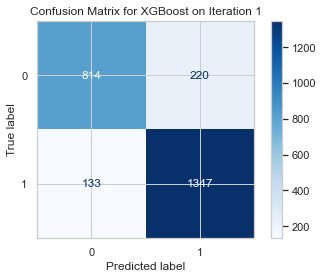

Running Logistic Regression...


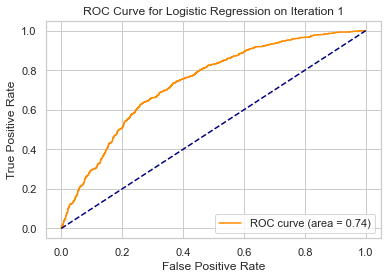

Logistic Regression F1 Score for Iteration 1: 0.7536


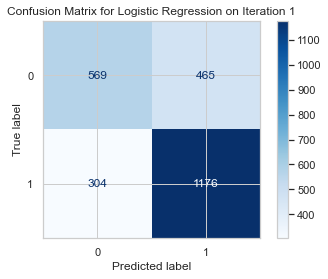

Iteration 2/10
Running KNN...


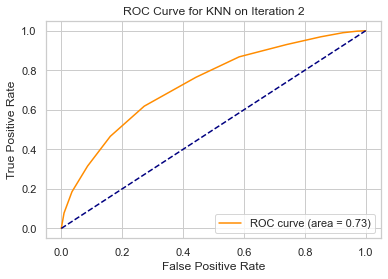

KNN F1 Score for Iteration 2: 0.7229


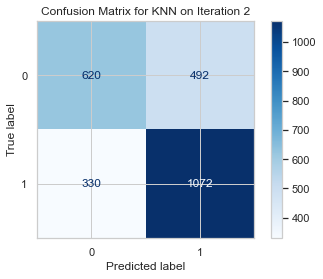

Running Naive Bayes...


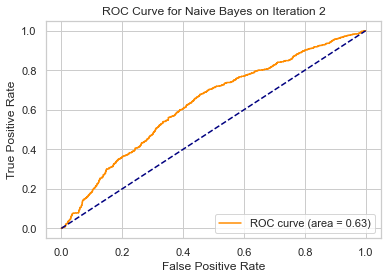

Naive Bayes F1 Score for Iteration 2: 0.6234


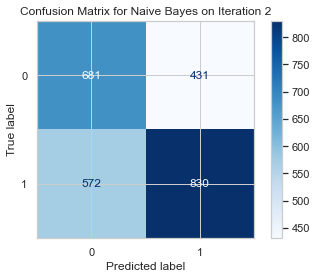

Running Random Forest...


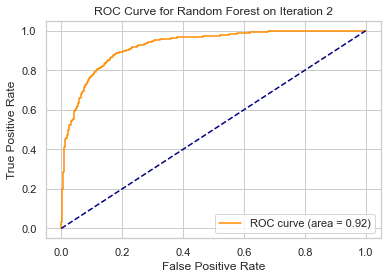

Random Forest F1 Score for Iteration 2: 0.8701


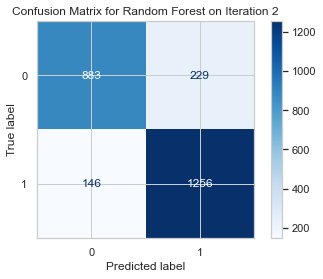

Running XGBoost...


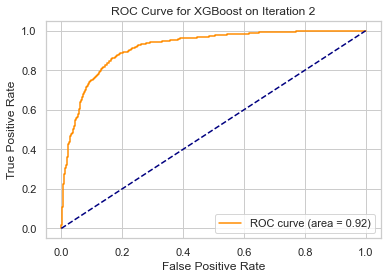

XGBoost F1 Score for Iteration 2: 0.8679


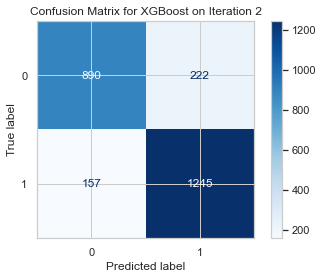

Running Logistic Regression...


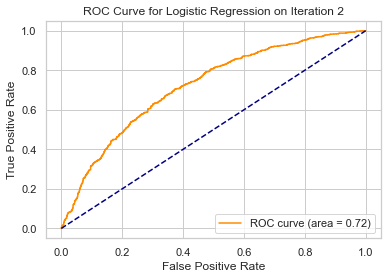

Logistic Regression F1 Score for Iteration 2: 0.7132


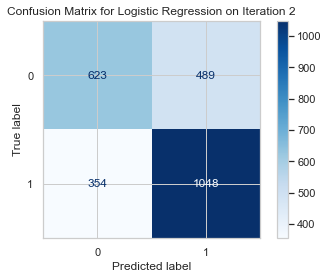

Iteration 3/10
Running KNN...


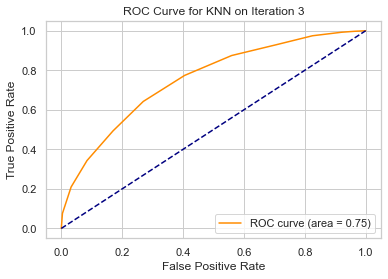

KNN F1 Score for Iteration 3: 0.7491


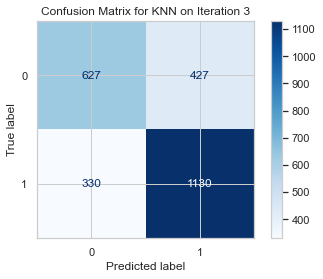

Running Naive Bayes...


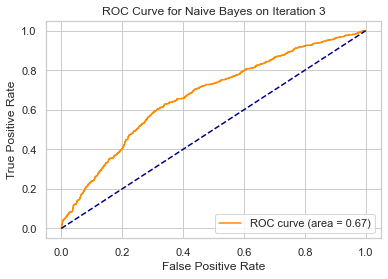

Naive Bayes F1 Score for Iteration 3: 0.6424


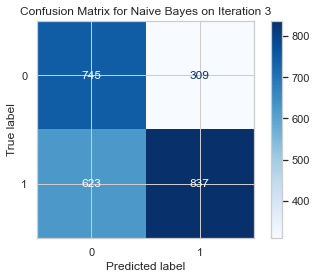

Running Random Forest...


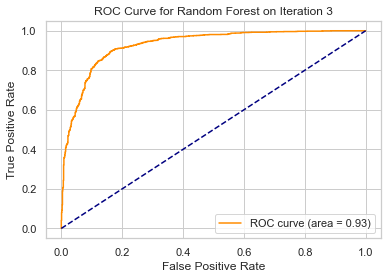

Random Forest F1 Score for Iteration 3: 0.8861


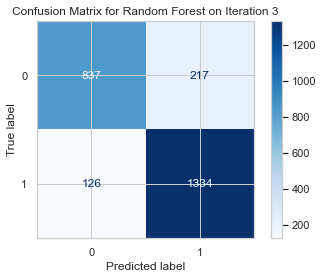

Running XGBoost...


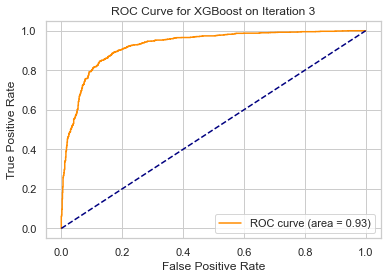

XGBoost F1 Score for Iteration 3: 0.8836


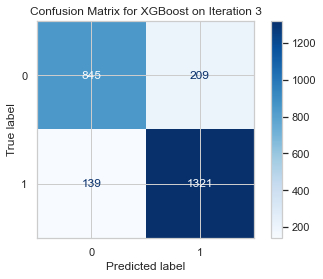

Running Logistic Regression...


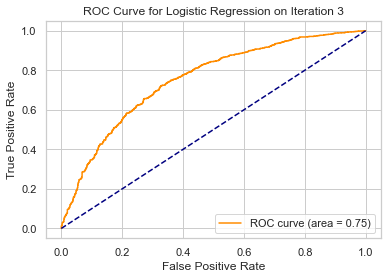

Logistic Regression F1 Score for Iteration 3: 0.7522


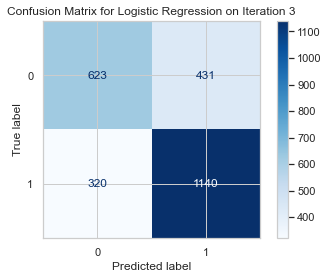

Iteration 4/10
Running KNN...


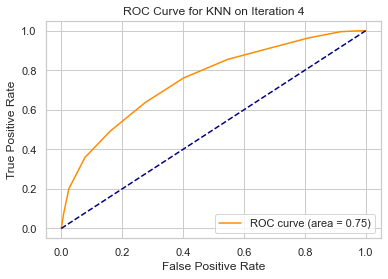

KNN F1 Score for Iteration 4: 0.7445


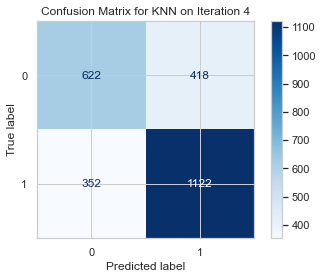

Running Naive Bayes...


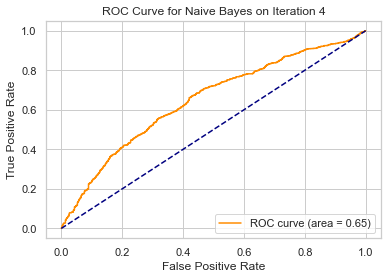

Naive Bayes F1 Score for Iteration 4: 0.6205


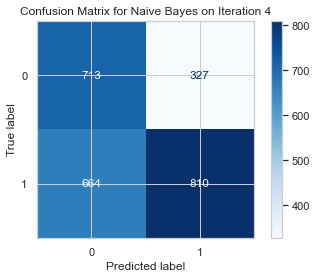

Running Random Forest...


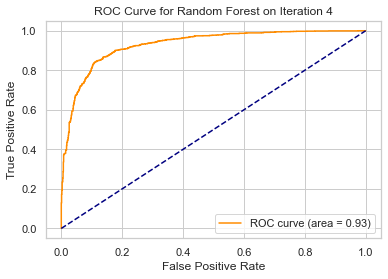

Random Forest F1 Score for Iteration 4: 0.8877


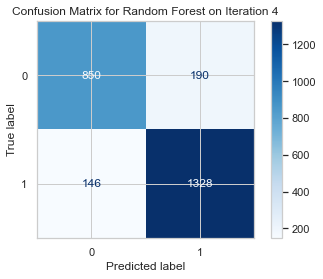

Running XGBoost...


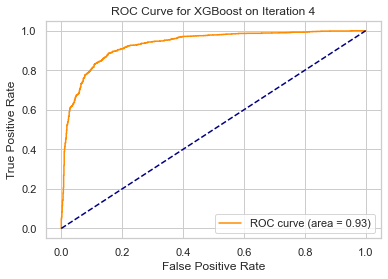

XGBoost F1 Score for Iteration 4: 0.8870


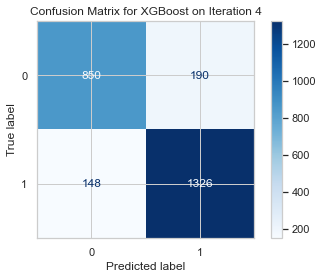

Running Logistic Regression...


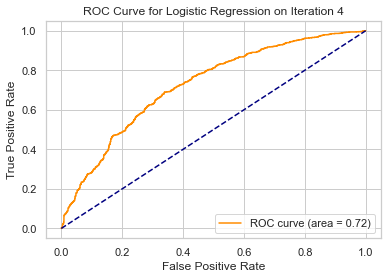

Logistic Regression F1 Score for Iteration 4: 0.7338


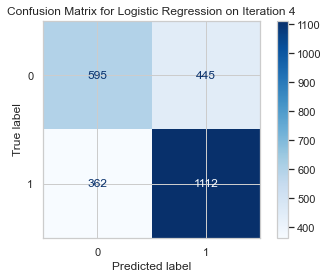

Iteration 5/10
Running KNN...


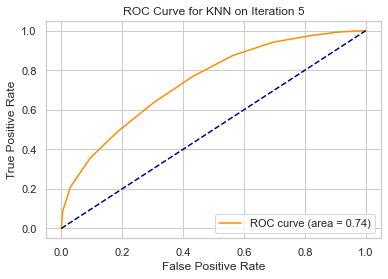

KNN F1 Score for Iteration 5: 0.7353


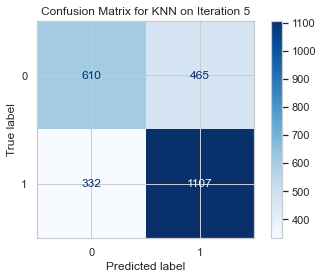

Running Naive Bayes...


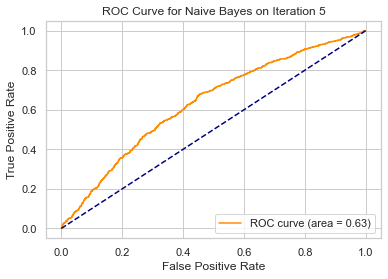

Naive Bayes F1 Score for Iteration 5: 0.6207


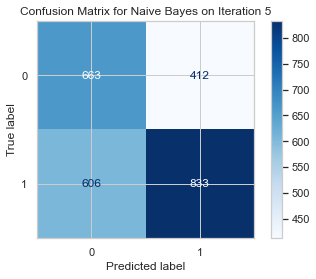

Running Random Forest...


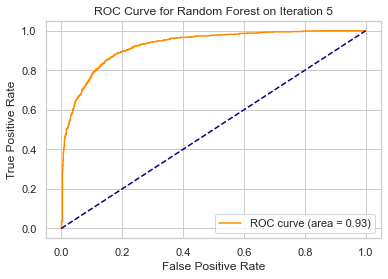

Random Forest F1 Score for Iteration 5: 0.8756


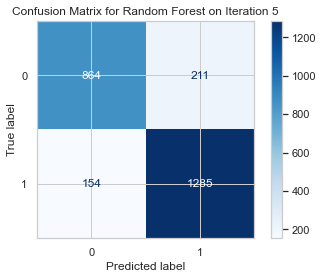

Running XGBoost...


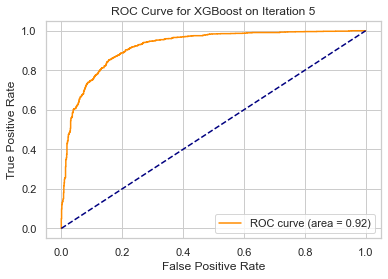

XGBoost F1 Score for Iteration 5: 0.8703


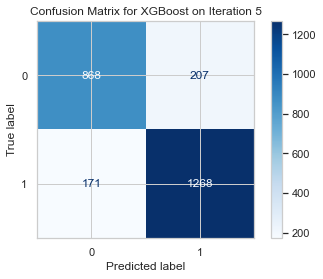

Running Logistic Regression...


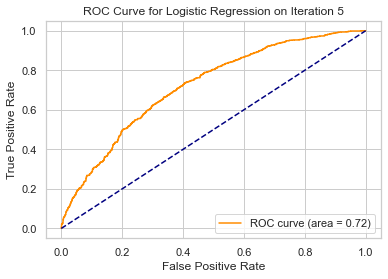

Logistic Regression F1 Score for Iteration 5: 0.7294


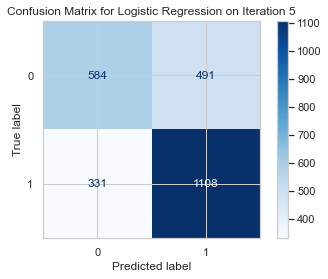

Iteration 6/10
Running KNN...


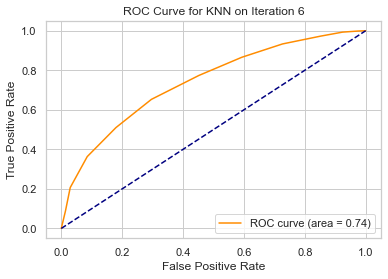

KNN F1 Score for Iteration 6: 0.7299


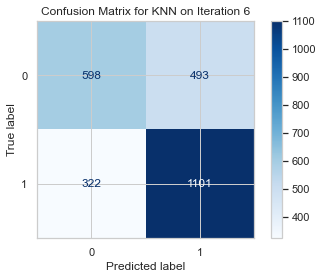

Running Naive Bayes...


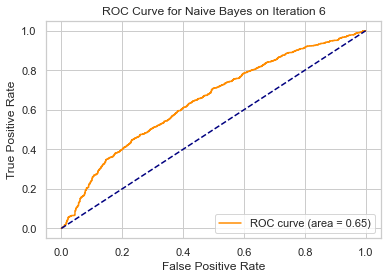

Naive Bayes F1 Score for Iteration 6: 0.6220


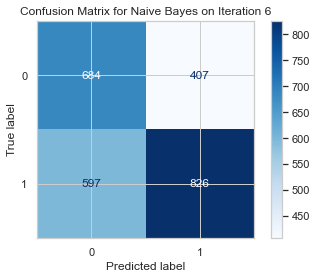

Running Random Forest...


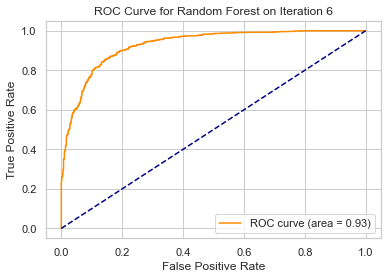

Random Forest F1 Score for Iteration 6: 0.8769


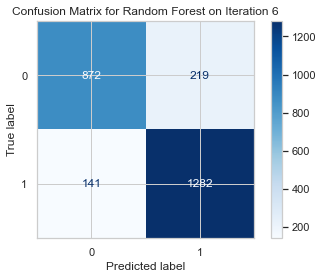

Running XGBoost...


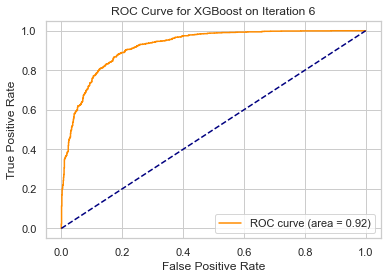

XGBoost F1 Score for Iteration 6: 0.8702


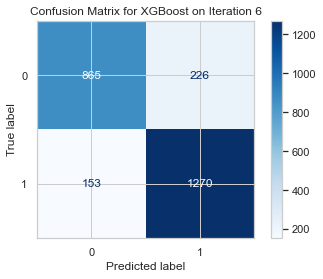

Running Logistic Regression...


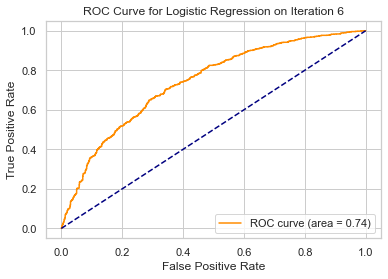

Logistic Regression F1 Score for Iteration 6: 0.7331


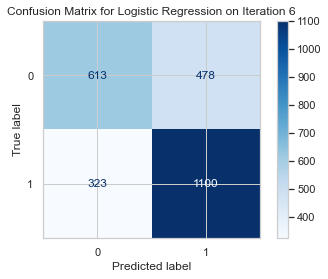

Iteration 7/10
Running KNN...


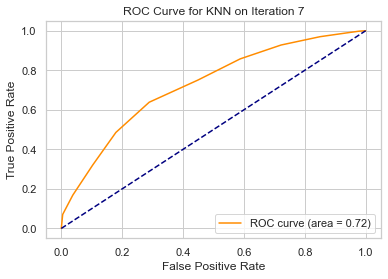

KNN F1 Score for Iteration 7: 0.7173


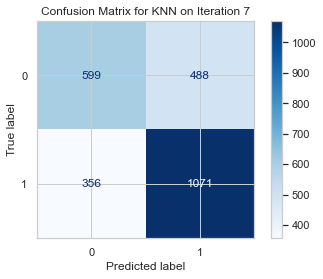

Running Naive Bayes...


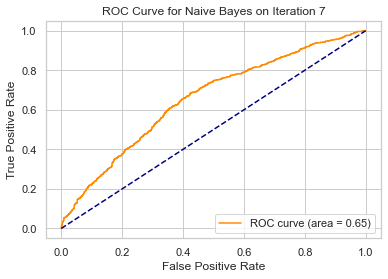

Naive Bayes F1 Score for Iteration 7: 0.6740


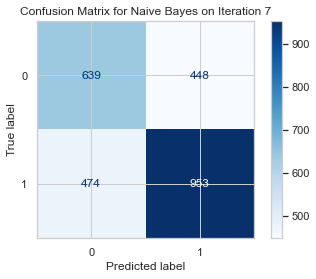

Running Random Forest...


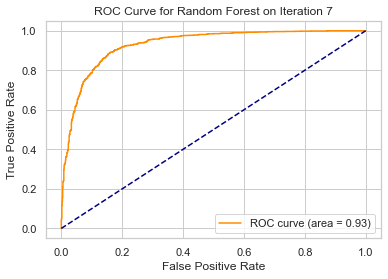

Random Forest F1 Score for Iteration 7: 0.8862


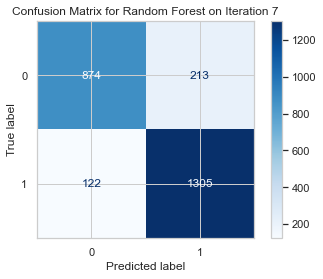

Running XGBoost...


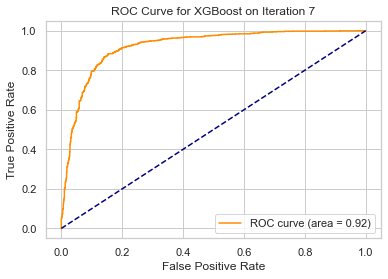

XGBoost F1 Score for Iteration 7: 0.8829


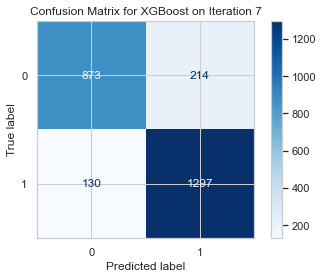

Running Logistic Regression...


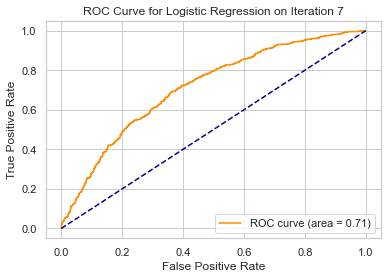

Logistic Regression F1 Score for Iteration 7: 0.7231


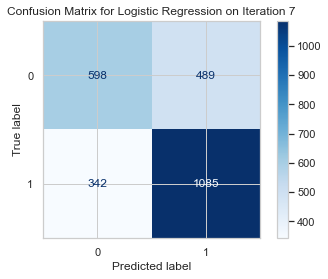

Iteration 8/10
Running KNN...


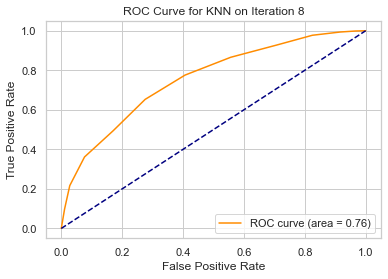

KNN F1 Score for Iteration 8: 0.7390


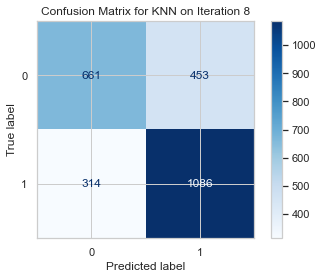

Running Naive Bayes...


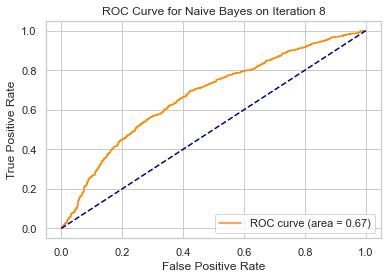

Naive Bayes F1 Score for Iteration 8: 0.6444


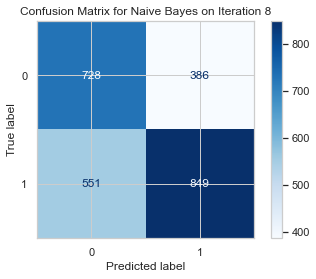

Running Random Forest...


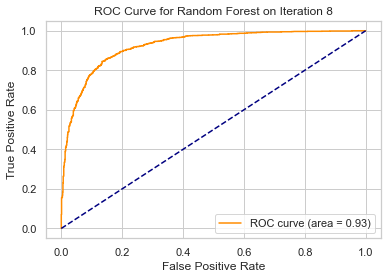

Random Forest F1 Score for Iteration 8: 0.8729


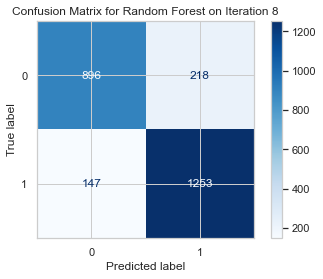

Running XGBoost...


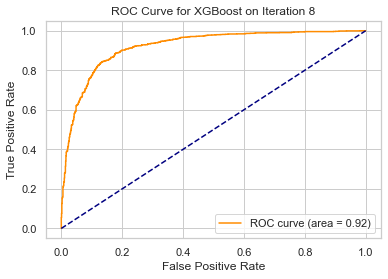

XGBoost F1 Score for Iteration 8: 0.8722


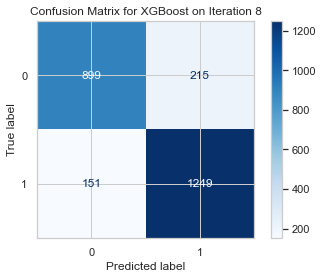

Running Logistic Regression...


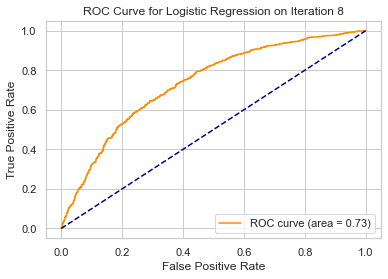

Logistic Regression F1 Score for Iteration 8: 0.7237


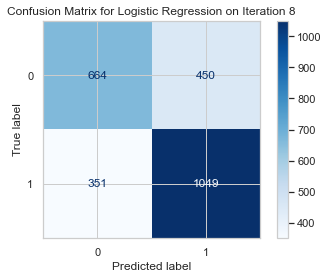

Iteration 9/10
Running KNN...


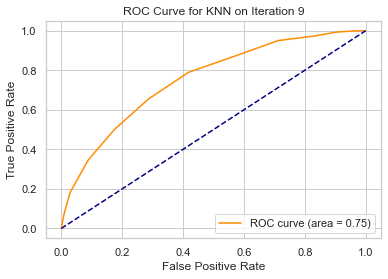

KNN F1 Score for Iteration 9: 0.7478


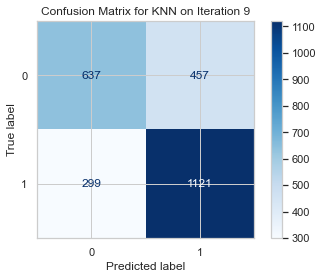

Running Naive Bayes...


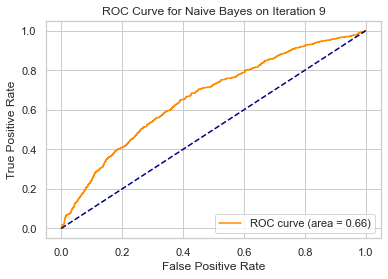

Naive Bayes F1 Score for Iteration 9: 0.6046


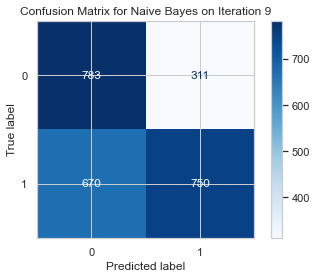

Running Random Forest...


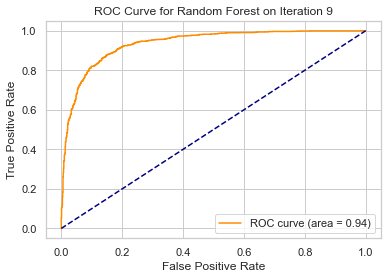

Random Forest F1 Score for Iteration 9: 0.8812


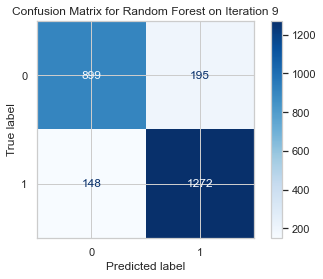

Running XGBoost...


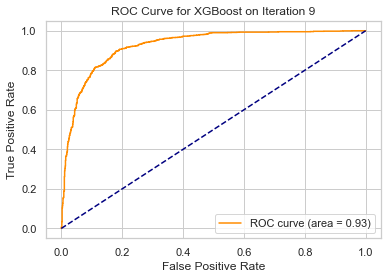

XGBoost F1 Score for Iteration 9: 0.8785


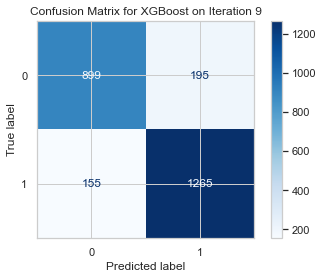

Running Logistic Regression...


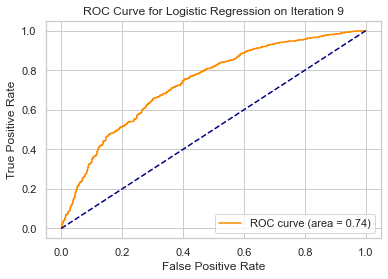

Logistic Regression F1 Score for Iteration 9: 0.7312


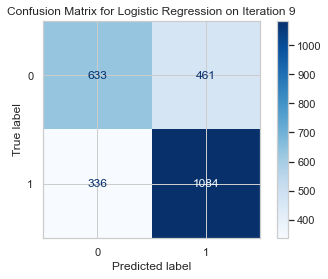

Iteration 10/10
Running KNN...


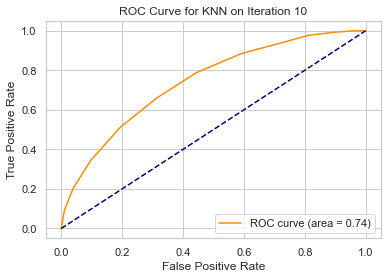

KNN F1 Score for Iteration 10: 0.7412


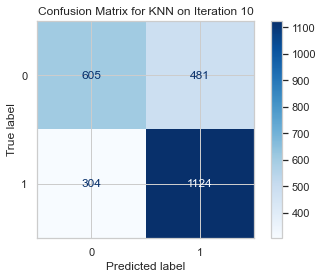

Running Naive Bayes...


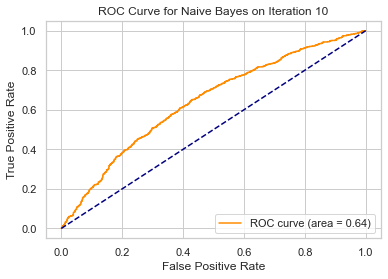

Naive Bayes F1 Score for Iteration 10: 0.6315


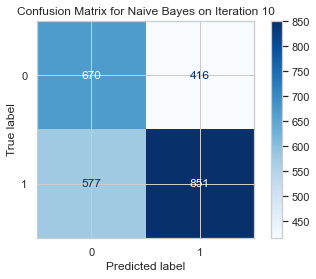

Running Random Forest...


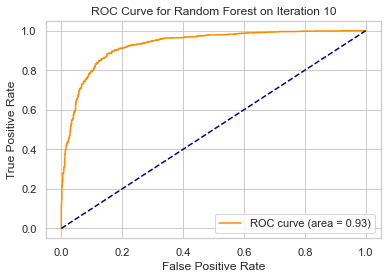

Random Forest F1 Score for Iteration 10: 0.8848


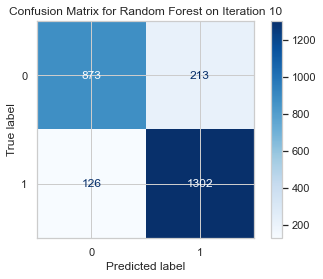

Running XGBoost...


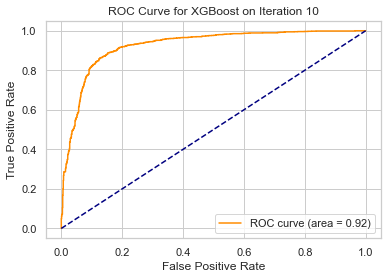

XGBoost F1 Score for Iteration 10: 0.8867


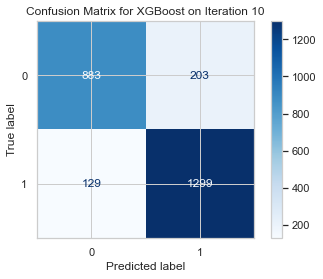

Running Logistic Regression...


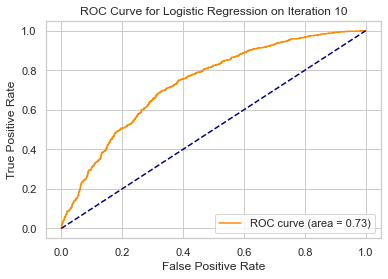

Logistic Regression F1 Score for Iteration 10: 0.7385


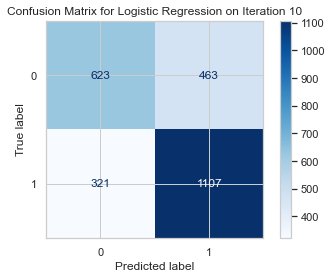

In [67]:
from sklearn.utils import resample

def bootstrap_evaluation(models, X, y, n_iterations=1000, sample_size=None):
    """
    Perform bootstrap evaluation for given models on data X, y.
    
    models: list of dictionaries, where each dictionary has 'name', 'preprocess', and 'classifier'
    X: Feature matrix
    y: Target vector
    n_iterations: Number of bootstrap iterations
    sample_size: Size of each bootstrap sample, if None, set to len(y)
    
    Returns: model scores for each iteration
    """
    if sample_size is None:
        sample_size = len(y)

    # Store scores for each model and iteration
    model_scores = {model['name']: [] for model in models}

    for i in range(n_iterations):
        print(f"Iteration {i+1}/{n_iterations}")
        # Sample data with replacement
        X_sample, y_sample = resample(X, y, n_samples=sample_size, replace=True)

        # Split into train and test sets (e.g., 80/20 split)
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=i)

        # Process, train, and evaluate each model
        for config in models:
            print(f"Running {config['name']}...")
            
            X_train_pp, X_test_pp = config['preprocess'](X_train, X_test, y_train)

            X_train_pp = np.ascontiguousarray(X_train_pp)
            X_test_pp = np.ascontiguousarray(X_test_pp)

            
            clf = config['classifier']
            clf.fit(X_train_pp, y_train)
            y_pred = clf.predict(X_test_pp)
    
            # ROC curve and AUC
            if len(set(y_test)) == 2:  # Ensure binary classification
                y_prob = clf.predict_proba(X_test_pp)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)

                plt.figure()
                plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for {config["name"]} on Iteration {i+1}')
                plt.legend(loc="lower right")
                plt.show()

            # F1 score
            f1 = f1_score(y_test, y_pred)
            print(f"{config['name']} F1 Score for Iteration {i+1}: {f1:.4f}")

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_test))
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix for {config["name"]} on Iteration {i+1}')
            plt.show()

            # Accuracy for the iteration
            score = accuracy_score(y_test, y_pred)
            model_scores[config['name']].append(score)

    return model_scores

# Use the same `model_configs` list from the previous K-fold CV example
bootstrap_scores = bootstrap_evaluation(model_configs, X, y, n_iterations=10)
# Maybe we need do run this for 50-100 times for stability

### Boostrapping results

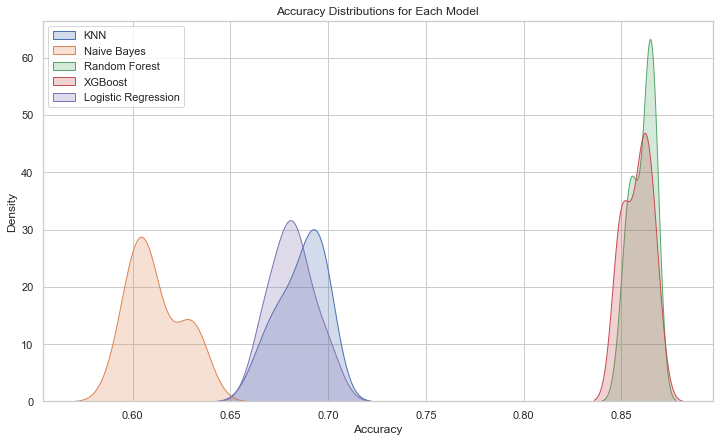

In [68]:
# Plot the scores, as distributions (not with distplot, it is deprecated), with the legend on the top left corner
plt.figure(figsize=(12, 7))
for model_name, scores in bootstrap_scores.items():
    sns.kdeplot(scores, label=model_name, fill=True)
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Accuracy Distributions for Each Model')
plt.legend(loc='upper left', bbox_to_anchor=(.0, 1))
plt.show()